In [153]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import pandas as pd
import numpy as np

import librosa


import progressbar

In [154]:
DATASET_PATH    = "D:/Research/Data/MIR/MagnaTagATune"

METADATA_PATH   = "%s/metadata" % DATASET_PATH
AUTIO_ROOT_PATH = "%s/mp3_full" % DATASET_PATH

# Process Metadata

## Read Metadata

In [155]:
metadata = pd.read_csv("%s/annotations_final.csv" % METADATA_PATH, sep="\t")
metadata.head()

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


### Expand filename of Metadata

In [156]:
metadata["mp3_path"] = AUTIO_ROOT_PATH + "/" + metadata.mp3_path

## Check if files exist

In [157]:
file_exist_mask = [os.path.exists(fn) for fn in metadata.mp3_path]

In [158]:
np.sum(file_exist_mask)

25863

## Separate Ground Truth from Metadata

In [159]:
ground_truth_annotations = metadata[[c for c in metadata.columns if c not in ["clip_id", "mp3_path"]]]
ground_truth_annotations.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,female singer,rap,metal,hip hop,quick,water,baroque,women,fiddle,english
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Separate Metadata

In [160]:
metadata = metadata[["clip_id", "mp3_path"]]

# Enrich Metadata

## Add Clip-Info

In [161]:
clip_info = pd.read_csv("%s/clip_info_final.csv" % METADATA_PATH, sep="\t")
clip_info = clip_info.drop("mp3_path", axis=1)
clip_info.head()

,clip_id,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
0,2,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,30,59,http://he3.magnatune.com/all/01--BWV54%20-%20I...
1,6,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,146,175,http://he3.magnatune.com/all/01--BWV54%20-%20I...
2,10,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,262,291,http://he3.magnatune.com/all/01--BWV54%20-%20I...
3,11,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,291,320,http://he3.magnatune.com/all/01--BWV54%20-%20I...
4,12,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,320,349,http://he3.magnatune.com/all/01--BWV54%20-%20I...


Merge with metadata

In [162]:
metadata = metadata.merge(clip_info, left_on="clip_id", right_on="clip_id", how="inner")
metadata.head()

,clip_id,mp3_path,track_number,title,artist,album,url,segmentStart,segmentEnd,original_url
0,2,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,30,59,http://he3.magnatune.com/all/01--BWV54%20-%20I...
1,6,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,146,175,http://he3.magnatune.com/all/01--BWV54%20-%20I...
2,10,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,262,291,http://he3.magnatune.com/all/01--BWV54%20-%20I...
3,11,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,291,320,http://he3.magnatune.com/all/01--BWV54%20-%20I...
4,12,D:/Research/Data/MIR/MagnaTagATune/mp3_full/f/...,1,BWV54 - I Aria,American Bach Soloists,J.S. Bach Solo Cantatas,http://www.magnatune.com/artists/albums/abs-so...,320,349,http://he3.magnatune.com/all/01--BWV54%20-%20I...


# Inspect Metadata

**Plot Most frequent Tags**

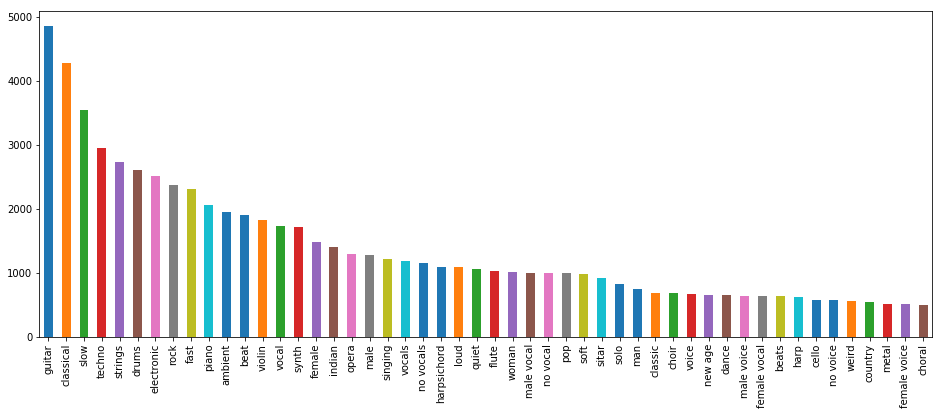

In [163]:
ground_truth_annotations.sum(axis=0).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(16,6));

**Plot Co-occurrences**

* Sorted by most frequent labels
* Shows most frequent labels and how they co-occurr
* Visualization to get an overview of Tag frequencies

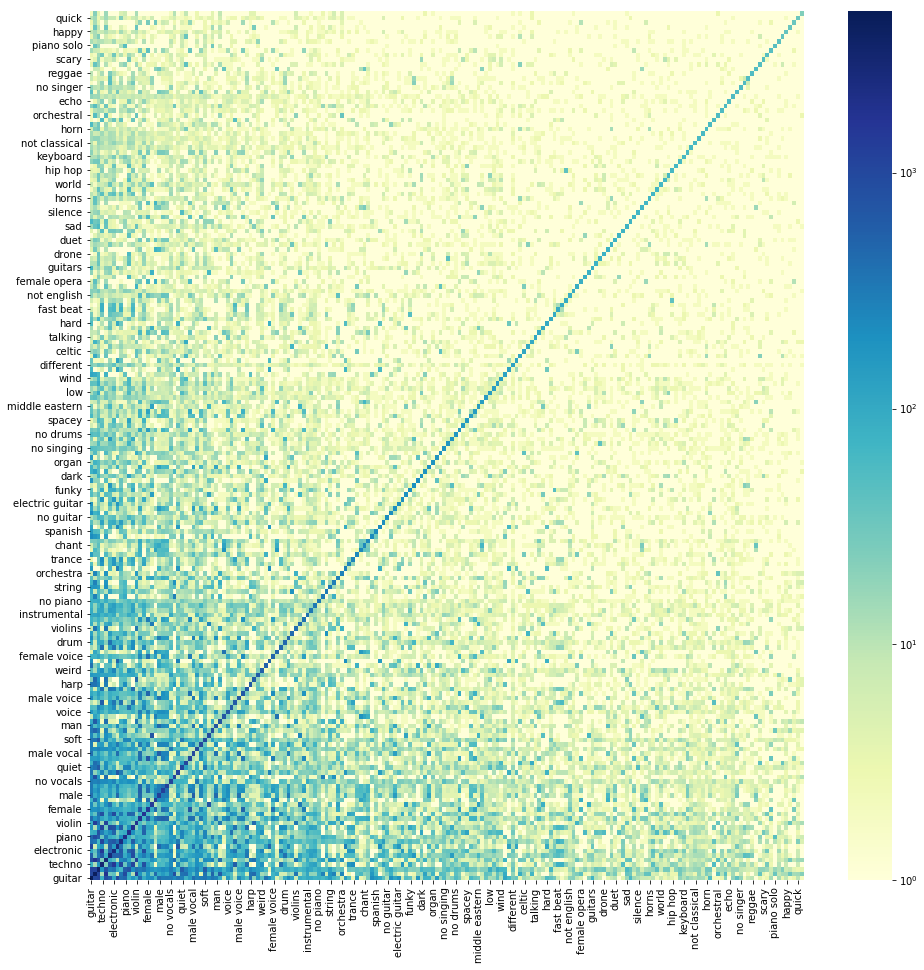

In [164]:
# calculate co-occurencies
coorc = ground_truth_annotations.T.dot(ground_truth_annotations)

# sort co-occurrence matrix
coorc = coorc.loc[coorc.max().sort_values(ascending=False).index]
coorc = coorc[coorc.max().sort_values(ascending=False).index]

# scale heat-map color encoding logarithmically
from matplotlib.colors import LogNorm

# shift by one to avoid log-domain error
coorc += 1

vmin = coorc.min().min()
vmax = coorc.max().max()

log_norm   = LogNorm(vmin=vmin, vmax=vmax)
cbar_ticks = [np.power(10, i) for i in np.arange(np.floor(np.log10(vmin)), 1+np.ceil(np.log10(vmax)))]

# plot
fig = plt.figure(figsize=(16,16))
ax = sns.heatmap(coorc, annot=False, cmap="YlGnBu", fmt='g', norm=log_norm, cbar_kws={"ticks": cbar_ticks});
ax.invert_yaxis()

## Post-Process Ground-Truth Labels

In [165]:
synonyms = [['beat', 'beats'],
            ['chant', 'chanting'],
            ['choir', 'choral'],
            ['classical', 'clasical', 'classic'],
            ['drum', 'drums'],
            ['electro', 'electronic', 'electronica', 'electric'],
            ['fast', 'fast beat', 'quick'],
            ['female', 'female singer', 'female singing', 'female vocals', 'female voice', 'woman', 'woman singing', 'women'],
            ['flute', 'flutes'],
            ['guitar', 'guitars'],
            ['hard', 'hard rock'],
            ['harpsichord', 'harpsicord'],
            ['heavy', 'heavy metal', 'metal'],
            ['horn', 'horns'],
            ['india', 'indian'],
            ['jazz', 'jazzy'],
            ['male', 'male singer', 'male vocal', 'male vocals', 'male voice', 'man', 'man singing', 'men'],
            ['no beat', 'no drums'],
            ['no singer', 'no singing', 'no vocal','no vocals', 'no voice', 'no voices', 'instrumental'],
            ['opera', 'operatic'],
            ['orchestra', 'orchestral'],
            ['quiet', 'silence'],
            ['singer', 'singing'],
            ['space', 'spacey'],
            ['string', 'strings'],
            ['synth', 'synthesizer'],
            ['violin', 'violins'],
            ['vocal', 'vocals', 'voice', 'voices'],
            ['strange', 'weird']]

**Merge synonym tags**

In [166]:
for synonym in synonyms:
    merged_values = ground_truth_annotations[synonym].sum(axis=1).clip(upper=1)
    ground_truth_annotations.drop(synonym, axis=1, inplace=True)
    ground_truth_annotations[synonym[0]] = merged_values.values

In [167]:
ground_truth_annotations.shape

(25863, 135)

# Prepare Partitions for Tutorial Examples

## Instrument Partition

In [168]:
genre = ['acoustic guitar', 'banjo', 'bass', 'bongos','cello','chimes','clarinet','classical guitar',
         'drum', 'electric guitar', 'male', 'female', 'fiddle', 'flute', 'guitar','harp','harpsichord',
         'horn','keyboard', 'lute','oboe','organ','percussion','piano','sax','sitar','string','synth',
         'trumpet','viola','violin','woodwind']

gt_example_instruments = ground_truth_annotations[genre]
gt_example_instruments.sum().sort_values(ascending=False)

guitar              4861
string              2842
drum                2698
male                2169
piano               2056
female              1996
violin              1907
synth               1734
harpsichord         1123
flute               1035
sitar                926
harp                 623
cello                575
bass                 337
classical guitar     225
electric guitar      203
banjo                194
organ                182
percussion           171
lute                 123
horn                 114
oboe                 107
sax                  101
fiddle                86
chimes                77
trumpet               75
keyboard              62
acoustic guitar       58
bongos                52
clarinet              49
woodwind              38
viola                 34
dtype: int64

Filter tracks with positive label

In [169]:
gt_example_instruments = gt_example_instruments[gt_example_instruments.sum(axis=1) > 0]

**Shrink Dataset**

Because in a tutorial time is always short, the number of tracks are reduced to reduce processing times.

* remove small classes

Original Size:

In [170]:
gt_example_instruments.shape

(16327, 32)

Remove small classes

In [171]:
gt_example_instruments = gt_example_instruments[gt_example_instruments.columns[gt_example_instruments.sum() > 100]]
gt_example_instruments = gt_example_instruments[gt_example_instruments.sum(axis=1) > 0]

In [172]:
gt_example_instruments.shape

(16253, 23)

In [173]:
gt_example_instruments.sum().sort_values(ascending=False)

guitar              4861
string              2842
drum                2698
male                2169
piano               2056
female              1996
violin              1907
synth               1734
harpsichord         1123
flute               1035
sitar                926
harp                 623
cello                575
bass                 337
classical guitar     225
electric guitar      203
banjo                194
organ                182
percussion           171
lute                 123
horn                 114
oboe                 107
sax                  101
dtype: int64

Resample classes

In [174]:
resampled_gt = []

for column in gt_example_instruments.T.sum(axis=1).sort_values(ascending=True).index.values:
    
    subset = gt_example_instruments[gt_example_instruments[column] == 1]
    resampled_gt.append(subset.sample(np.min([subset.shape[0], 100]), random_state=1))
    
gt_example_instruments = pd.concat(resampled_gt, axis=0)

Final Set size

In [175]:
gt_example_instruments.shape

(2300, 23)

In [176]:
gt_example_instruments.sum().sort_values(ascending=False)

guitar              804
string              657
drum                397
violin              382
piano               321
harpsichord         262
flute               255
synth               214
harp                211
male                198
cello               175
female              170
sitar               162
classical guitar    158
horn                146
oboe                137
bass                135
lute                130
sax                 123
percussion          117
banjo               116
electric guitar     111
organ               109
dtype: int64

### Store Data

In [177]:
# Filter and store Metadata
metadata.loc[gt_example_instruments.index].to_csv("%s/ismir2018_tut_part_2_instruments_metadata.csv" % METADATA_PATH)
# store labels
gt_example_instruments.to_csv("%s/ismir2018_tut_part_2_instruments_labels.csv" % METADATA_PATH)

## Genre Partition

### Define Genre Labels

In [178]:
genre = ["blues", "classical", "country", "jazz", "pop", "rock", "techno"]

gt_example_genres = ground_truth_annotations[genre]
gt_example_genres.sum().sort_values(ascending=False)

classical    4358
techno       2954
rock         2371
pop           995
jazz          555
country       541
blues         181
dtype: int64

Filter tracks with positive label

In [179]:
gt_example_genres = gt_example_genres[gt_example_genres.sum(axis=1) > 0]
gt_example_genres.sum().sum()

11955

Remove Multi-lables instances => convert to single label/multi-class ground-truth

In [180]:
gt_example_genres = gt_example_genres[gt_example_genres[genre].sum(axis=1) == 1]
gt_example_genres.sum().sum()

9777

In [181]:
gt_example_genres.sum().sort_values(ascending=False)

classical    4303
techno       2599
rock         1758
pop           449
jazz          373
country       265
blues          30
dtype: int64

### Balance Dataset

Convert One-Hot encoded labels to String Labels

In [182]:
gt_labels = gt_example_genres.apply(lambda row: gt_example_genres.columns[np.argmax(row.values)], axis=1).to_frame("genre")
gt_labels.head()

,genre
0,classical
1,classical
2,classical
4,classical
5,techno


Size of original set:

In [183]:
gt_labels.shape

(9777, 1)

Group by labels and reduce genres to max. 500 tracks

In [184]:
gt_labels = gt_labels.groupby("genre").apply(lambda x: x.sample(np.min([x.shape[0], 500]), random_state=2))
gt_labels = gt_labels.reset_index(0, drop=True)

Size of reduced set:

In [185]:
gt_labels.shape

(2617, 1)

Re-encode using One-Hot encoding

In [186]:
gt_example_genres = pd.get_dummies(gt_labels, prefix="", prefix_sep="")

gt_example_genres.sum().sort_values(ascending=False)

techno       500
rock         500
classical    500
pop          449
jazz         373
country      265
blues         30
dtype: int64

### Store Data

In [187]:
# Filter and store Metadata
metadata.loc[gt_example_genres.index].to_csv("%s/ismir2018_tut_part_2_genre_metadata.csv" % METADATA_PATH)
# store labels
gt_example_genres.to_csv("%s/ismir2018_tut_part_2_genre_labels.csv" % METADATA_PATH)

## Mood Partition

In [188]:
moods = ['airy','calm','dark','eerie','happy','light','sad','scary','soft','strange']

gt_example_moods = ground_truth_annotations[moods]
gt_example_moods.sum().sort_values(ascending=False)

soft       985
strange    640
dark       193
calm       131
sad         72
airy        66
eerie       65
light       62
scary       49
happy       37
dtype: int64

Filter tracks with positive label

In [189]:
gt_example_moods = gt_example_moods[gt_example_moods.sum(axis=1) > 0]

In [190]:
gt_example_moods.shape

(2047, 10)

### Store Data

In [191]:
# Filter and store Metadata
metadata.loc[gt_example_moods.index].to_csv("%s/ismir2018_tut_part_2_moods_metadata.csv" % METADATA_PATH)
# store labels
gt_example_moods.to_csv("%s/ismir2018_tut_part_2_moods_labels.csv" % METADATA_PATH)

## Similarity Retrieval

In [192]:
gt_all = pd.concat([gt_example_instruments,
                    gt_example_genres,
                    gt_example_moods], sort=False)

In [193]:
gt_all.shape

(6964, 40)

Drop Duplicates and keep only indexes

In [194]:
gt_all_idx = gt_all.index.drop_duplicates(keep='first')
gt_all_idx.shape

(6067,)

In [195]:
gt_example_similarity = ground_truth_annotations.loc[gt_all_idx]

In [196]:
resampled_gt = []

for column in gt_example_similarity.T.sum(axis=1).sort_values(ascending=True).index.values:
    
    subset = gt_example_similarity[gt_example_similarity[column] == 1]
    resampled_gt.append(subset.sample(np.min([subset.shape[0], 30]), random_state=1))
    
gt_similartiy_retrieval = pd.concat(resampled_gt, axis=0)
gt_similartiy_retrieval = gt_similartiy_retrieval[gt_similartiy_retrieval.sum(axis=1) > 0]

Size of dataset

In [197]:
gt_similartiy_retrieval.shape

(3662, 135)

In [198]:
gt_all_idx = gt_similartiy_retrieval.index.drop_duplicates(keep='first')

gt_similartiy_retrieval = ground_truth_annotations.loc[gt_all_idx].sort_index()

In [199]:
gt_similartiy_retrieval.shape

(2561, 135)

Frequency distribution of Tags

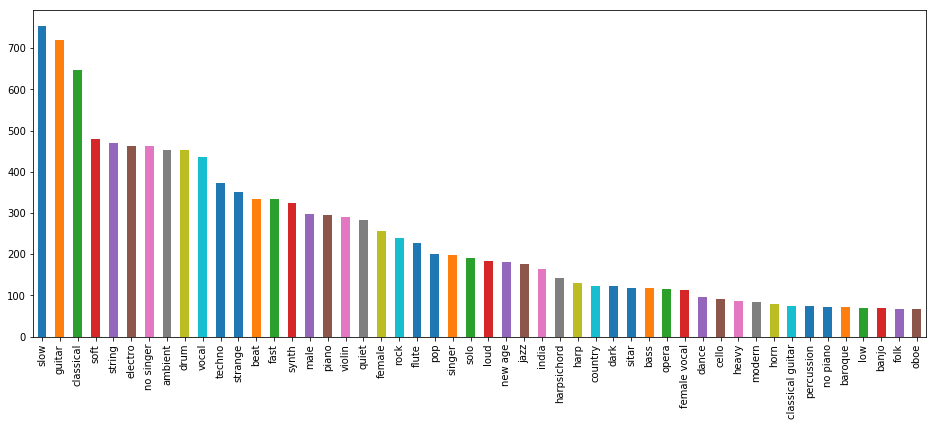

In [200]:
gt_similartiy_retrieval.sum(axis=0).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(16,6));

### Store Data

In [201]:
# Filter and store Metadata
metadata.loc[gt_similartiy_retrieval.index].to_csv("%s/ismir2018_tut_part_3_similartiy_metadata.csv" % METADATA_PATH)
# store labels
gt_similartiy_retrieval.to_csv("%s/ismir2018_tut_part_3_similarity_labels.csv" % METADATA_PATH)

# Prepare Data / Extract Features

## Prepare Spectrogram Inputs for Deep Neural Networks

Final dataset size:

In [202]:
gt_all_idx.shape

(2561,)

In [203]:
metadata_to_extract = metadata.loc[gt_all_idx]

### Audio Metadata Analysis

Get Length of audio files (in seconds)

In [204]:
pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

audio_metadata = []

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    try:
        # load audio data
        wave_data, sample_rate = librosa.core.load(row.mp3_path, 
                                                   sr    = None, 
                                                   mono  = False)

        audio_metadata.append([wave_data.shape[0], sample_rate])
        
    except Exception as e:
        print(e)

100% (2561 of 2561) |####################| Elapsed Time: 0:03:35 Time:  0:03:35


In [205]:
audio_metadata = pd.DataFrame(audio_metadata, columns=["length", "samplerate"], index=metadata_to_extract.index)

In [206]:
audio_metadata.describe()

,length,samplerate
count,2561.0,2561.0
mean,465984.0,16000.0
std,0.0,0.0
min,465984.0,16000.0
25%,465984.0,16000.0
50%,465984.0,16000.0
75%,465984.0,16000.0
max,465984.0,16000.0


**Conclusions: Audio metadata anaylsis**

* all audio files have same samplerate: 16000Hz
* all audio files have same number of samples: 465984
* ==> all tracks are 29.124s long
* tracks are already single channel (mono)

In [207]:
features = []

# length = fft_hop_length * num windows (simplified calculation)
length = 1024 * 81

# take the segment from the center of the audio file
offset = int(465984 - (length / 2))

pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    # load audio data
    wave_data, sample_rate = librosa.core.load(row.mp3_path, 
                                               sr    = None, 
                                               mono  = True, 
                                               dtype = np.float32)
    
    # normalize input amplitude
    wave_data = librosa.util.normalize(wave_data)
    
    # time-frequency transformation with Mel-scaling
    spectrogram = librosa.feature.melspectrogram(wave_data[offset:offset+length],
                                                 sr=sample_rate,
                                                 n_fft      = 2048,
                                                 hop_length = 1024,
                                                 n_mels     = 80,
                                                 power      = 2.0,
                                                 norm       = 1)
    
    # transform to Decibel scale
    spectrogram = librosa.power_to_db(spectrogram)

    # re-shape to final segment size
    spectrogram = spectrogram.astype(np.float32)
    spectrogram = spectrogram[:,:80]
    
    features.append(spectrogram)

100% (2561 of 2561) |####################| Elapsed Time: 0:02:55 Time:  0:02:55


In [208]:
features = np.asarray(features)

### Store Data

In [209]:
np.savez("%s/ISMIR2018_tut_Magnagtagatune_spectrograms.npz" % DATASET_PATH, features=features, index=metadata_to_extract.index.values)

## Extract Features

**Rhythm Patterns Feature-set**

RP_extract is a Python library to extract semantic features (so called audio descriptors) from audio files (WAV, MP3, ...).

Github: https://github.com/tuwien-musicir/rp_extract

In [210]:
import rp_extract as rp

In [ ]:
features = []

pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    # load audio data
    wave_data, sample_rate = librosa.core.load(row.mp3_path, 
                                               sr    = 44100, 
                                               mono  = True, 
                                               dtype = np.float32)
    
    # normalize input amplitude
    wave_data = librosa.util.normalize(wave_data)
    
    # extract features
    feat = rp.rp_extract(wave_data,
                         sample_rate,
                         extract_rp          = True,
                         extract_ssd         = True,
                         extract_rh          = False,
                         extract_mvd         = False,
                         extract_tssd        = False,
                         extract_trh         = False,
                         n_bark_bands        = 24,
                         spectral_masking    = True,
                         transform_db        = True,
                         transform_phon      = True,
                         transform_sone      = True,
                         fluctuation_strength_weighting = True,
                         skip_leadin_fadeout = 0,
                         step_width          = 1,
                         mod_ampl_limit      = 60,
                         verbose             = False)
    
    
    features.append(feat)

N/A% (0 of 2561) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--C:\anaconda\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
 59% (1530 of 2561) |###########         | Elapsed Time: 0:25:17 ETA:   0:17:20

In [ ]:
featureset_rp  = np.asarray([feat["rp"]  for feat in features])
featureset_ssd = np.asarray([feat["ssd"] for feat in features])

In [ ]:
np.savez("%s/ISMIR2018_tut_Magnagtagatune_rp_features.npz" % DATASET_PATH, 
         rp    = featureset_rp, 
         ssd   = featureset_ssd, 
         index = metadata_to_extract.index.values)